# Project and Data Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 

We will have access to a dataset of 10,000 tweets that were hand classified. The data has 5 columns. 'ID', 'keyword', 'location', 'text' and 'target'. We will primarily be using the text column for classification and use the target column as our target variable. The positive and negative labels are 1 and 0 repectively. The traning set contains approximately 3300 unlabeled rows.

### Import all libraries

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')


In [2]:
import re
import nltk
from nltk.util import ngrams
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\will.pratt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

## Exploratory Data Analysis

In [27]:
train = pd.read_csv('../desktop/train.csv')
test = pd.read_csv('../desktop/test.csv')

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [7]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's first look at how many missing values we have in "keyword" and "location" columns

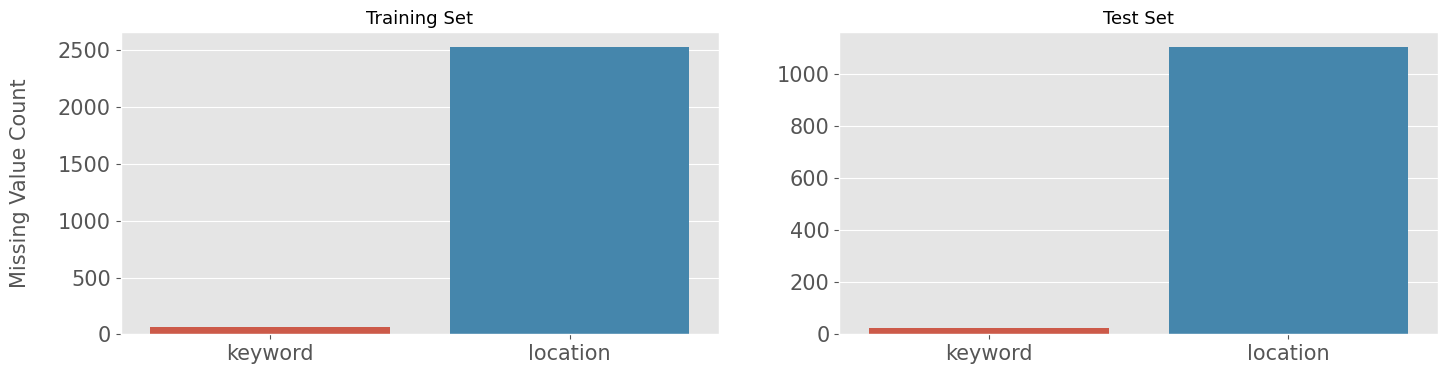

In [8]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train[missing_cols].isnull().sum().index, y=train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test[missing_cols].isnull().sum().index, y=test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

It looks like location has a lot more nulls than keyword in both the test and training set. We will certainly have to clean these later

Next, let's look at the distribution of disaster tweets as compared to non disaster tweets

In [9]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

The split between 0 and 1 labels seems to be fairly even. I do not think we need to stratify further. I will visualize this difference below.

<AxesSubplot:ylabel='target'>

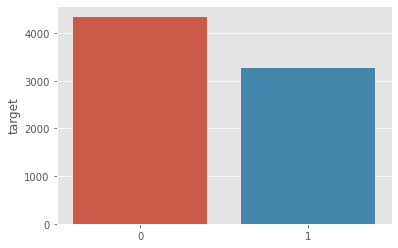

In [10]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts())

Next let's look at a few examples of disaster tweets compared to non disaster tweets

In [11]:
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1:10]

array(['Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
       '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
       '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
       "I'm on top of the hill and I can see a fire in the woods...",
       "There's an emergency evacuation happening now in the building across the street",
       "I'm afraid that the tornado is coming to our area..."],
      dtype=object)

In [12]:
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1:10]

array(['I love fruits', 'Summer is lovely', 'My car is so fast',
       'What a goooooooaaaaaal!!!!!!', 'this is ridiculous....',
       'London is cool ;)', 'Love skiing', 'What a wonderful day!',
       'LOOOOOOL'], dtype=object)

Interesting in that it appears maybe the disaster tweets have more words than non disaster tweets, at least for the first 10 examples. We can explore this further by visualizing it.

Text(0.5, 0.98, 'Characters in tweets')

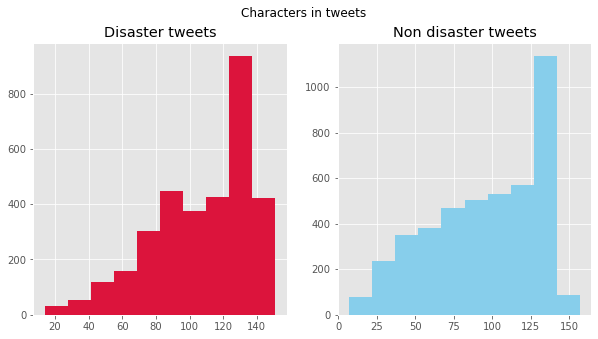

In [13]:
#Number of characters in tweets
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='crimson')
ax1.set_title('Disaster tweets')
tweet_len = train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('Non disaster tweets')
fig.suptitle('Characters in tweets')

Text(0.5, 0.98, 'Words in a tweet')

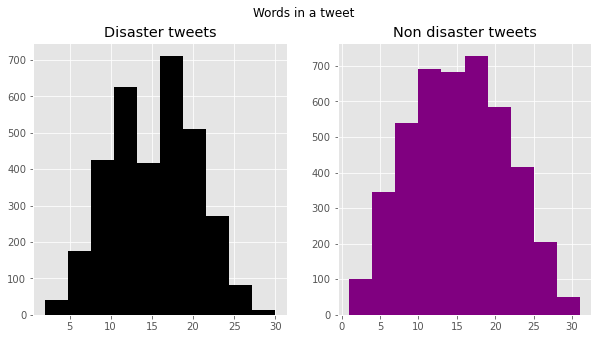

In [14]:
#Number of words in a tweet
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='black')
ax1.set_title('Disaster tweets')
tweet_len = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='purple')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

There does not seem to be too big of a difference between the two. We can take this a step further and look at average word length.

Text(0.5, 0.98, 'Average word length in each tweet')

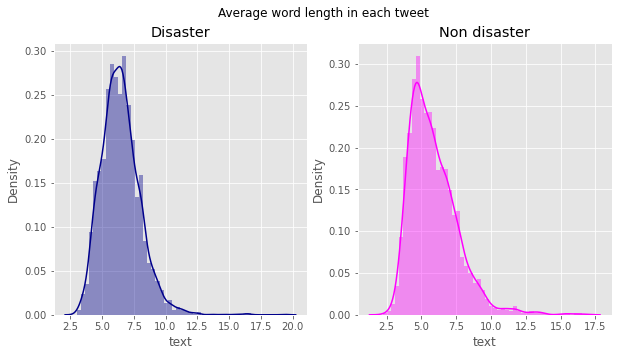

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word = train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='darkblue')
ax1.set_title('Disaster')
word = train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='magenta')
ax2.set_title('Non disaster')
fig.suptitle('Average word length in each tweet')

Next lets look at the keyword column. We can visualize the top 25 keywords.

<AxesSubplot:xlabel='keyword'>

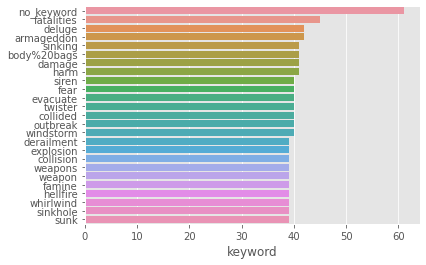

In [16]:
sns.barplot(y=train['keyword'].value_counts()[:25].index,x=train['keyword'].value_counts()[:25],orient='h')

Many of these words appear to have a very negative connotation. We will split up the top words between disaster and non disaster tweets.

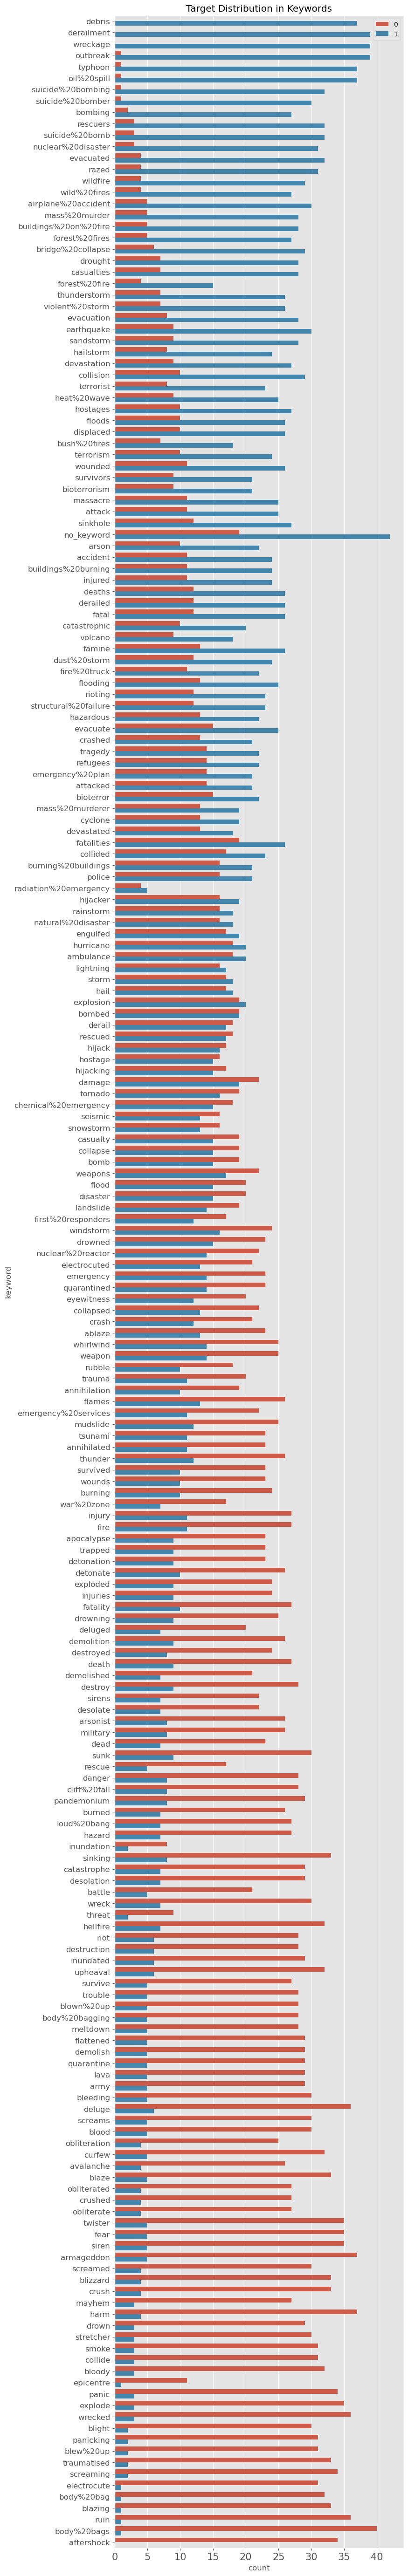

In [17]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

Lastly we can look at the location column

<AxesSubplot:xlabel='keyword'>

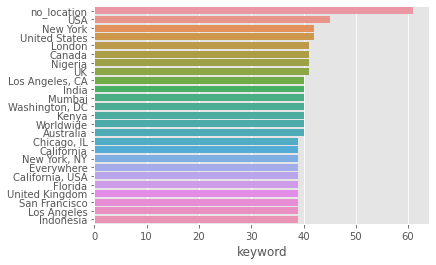

In [18]:
sns.barplot(y=train['location'].value_counts()[:25].index,x=train['keyword'].value_counts()[:25],orient='h')

It appears the locations are not consistent across the dataset. For example we have some the just list USA and others that list California, USA. For our preprocessing we will standardize the locations and then clean our text. We can do this by removing things like emojis and whitespaces and by making all text lowercase. This along with a few other cleaning procedures will help to boost our accuracy. We can also apply spellcheck to our data to help make it more consistent and tokenize it.

## Preprocessing

First let's standardize all locations

<AxesSubplot:xlabel='location'>

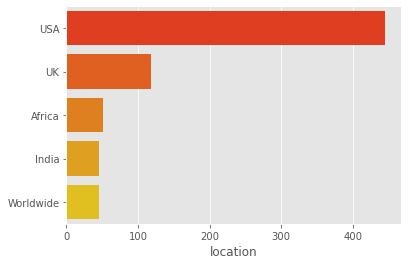

In [28]:
#Renaming location names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y = train['location'].value_counts()[:5].index, x = train['location'].value_counts()[:5],
            palette='autumn', orient='h')

<AxesSubplot:xlabel='location'>

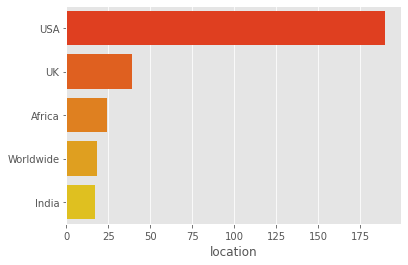

In [29]:
#Renaming location names
test['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y = test['location'].value_counts()[:5].index, x = test['location'].value_counts()[:5],
            palette='autumn', orient='h')

In [30]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

train['text'] = train['text'].apply(lambda x: remove_emoji(x))
test['text'] = test['text'].apply(lambda x: remove_emoji(x))

In [31]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
import string

In [33]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))
# Let's take a look at the updated text
train['text'].head()
test['text'].head()

0                   just happened a terrible car crash
1    heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                apocalypse lighting spokane wildfires
4          typhoon soudelor kills  in china and taiwan
Name: text, dtype: object

In [34]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
train['text'] = train['text'].apply(lambda x : correct_spellings(x))
test['text'] = test['text'].apply(lambda x : correct_spellings(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la range ask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [35]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [36]:
train['text'] = train['text'].apply(lambda x: toremove_stopword(x))
test['text'] = test['text'].apply(lambda x: toremove_stopword(x))
# Let's take a look at the updated text
train['text'].head()
test['text'].head()

0                     [happened, terrible, car, crash]
1    [heard, earthquake, different, cities, stay, s...
2    [forest, fire, spot, pond, geese, fleeing, acr...
3           [apocalypse, lighting, spokane, wildfires]
4            [typhoon, soudelor, kills, china, taiwan]
Name: text, dtype: object

In [37]:
import tensorflow as tf

In [38]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.oov_token = '<oovToken>'
tokenizer.fit_on_texts(train.text)
vocab = tokenizer.word_index
vocabCount = len(vocab)+1

vocabCount

15148

In [39]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la range ask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X = train[['text']]
X

,text
0,deeds reason earthquake may allah forgive us
1,forest fire near la range ask canada
2,residents asked shelter place notified officer...
3,people receive wildfires evacuation orders cal...
4,got sent photo ruby alaska smoke wildfires pou...
...,...
7608,two giant cranes holding bridge collapse nearb...
7609,ariaahrary thetawniest control wild fires cali...
7610,volcano hawaii
7611,police investigating bike collided car little ...


In [42]:
X = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X.text.to_numpy()), padding='pre')
#X_test = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_test.text.to_numpy()), padding='pre')
y = train.target.to_numpy()
X.shape, y.shape

((7613, 22), (7613,))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train

array([[    0,     0,     0, ...,   589,   471,   895],
       [    0,     0,     0, ...,   303,  2405, 13720],
       [    0,     0,     0, ...,    78,     7,    11],
       ...,
       [    0,     0,     0, ...,  1149,   726,  7129],
       [    0,     0,     0, ...,   678, 15146, 15147],
       [    0,     0,     0, ...,    55,   305,    28]])

## Model Creation

For the purposes of this mini-project we will first try a bidirectional LSTM and then a more traditional LSTM model. To begin, an RNN uses feedback loops which makes it different from other neural networks. Those loops help RNN to process the sequence of the data.
Long short term memory networks (LSTM) are a special kind of RNN. They were introduced to avoid the long-term dependency problem. In regular RNN, the problem frequently occurs when connecting previous information to new information.

Bidirectional LSTM is the process of making any neural network to have the sequence information in both directions backwards (future to past) or forward (past to future). 

In bidirectional, our input flows in two directions, making a bi-lstm different from the regular LSTM. With the regular LSTM, we can make input flow in one direction, either backwards or forward. However, in bi-directional, we can make the input flow in both directions to preserve the future and the past information.

We will be able to see the difference in performance of each below. Please note that the hyperparameters are slightly different for each as well.

Lastly we will be using a word embedding matrix. Simply put, a word embedding layer in the LSTM maps word indices to vectors.

In [83]:
tweet_1 = train.text.values
test_1 = test.text.values
sentiments = train.target.values

In [84]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(tweet_1)
vocab_length = len(word_tokenizer.word_index) + 1

In [85]:
embeddings_dictionary = dict()
embedding_dim = 100

In [86]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [87]:
def BLSTM():
    model = Sequential()
    model.add(keras.layers.Embedding(input_dim=vocabCount+1, output_dim=64, input_length=31))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [88]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [89]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=8
                             )
checkpointer = ModelCheckpoint(filepath="clf-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]
h = model.fit(
    X_train, 
    y_train, 
    epochs = 10,
    batch_size = 32,
    validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [checkpointer, earlystopping, reduce_lr]
)

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9839
Epoch 00001: val_loss improved from inf to 0.94836, saving model to clf-weights.hdf5
179/179 [==============================] - 3s 15ms/step - loss: 0.0389 - accuracy: 0.9839 - val_loss: 0.9484 - val_accuracy: 0.7574 - lr: 2.0000e-04
Epoch 2/10
176/179 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9853
Epoch 00002: val_loss did not improve from 0.94836
179/179 [==============================] - 3s 15ms/step - loss: 0.0385 - accuracy: 0.9855 - val_loss: 0.9559 - val_accuracy: 0.7658 - lr: 2.0000e-04
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9844
Epoch 00003: val_loss improved from 0.94836 to 0.92566, saving model to clf-weights.hdf5
179/179 [==============================] - 3s 15ms/step - loss: 0.0384 - accuracy: 0.9844 - val_loss: 0.9257 - val_accuracy: 0.7684 - lr: 2.0000e-04
Epoch 4/10
179/179 [====================

In [90]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

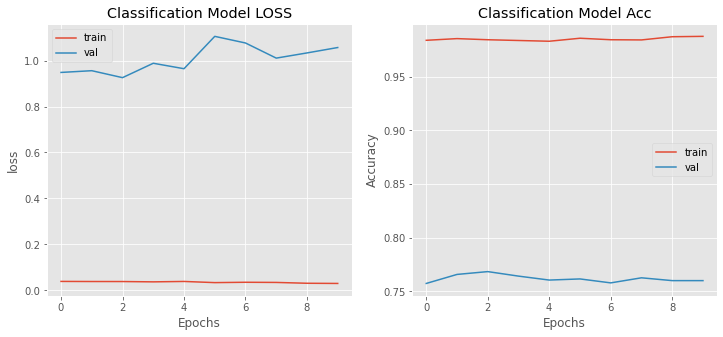

In [91]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [92]:
y_pred = model.predict(X_test).round()

In [93]:
y_pred

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [95]:
conm = confusion_matrix(y_test,y_pred)
conm

array([[854, 237],
       [220, 593]], dtype=int64)

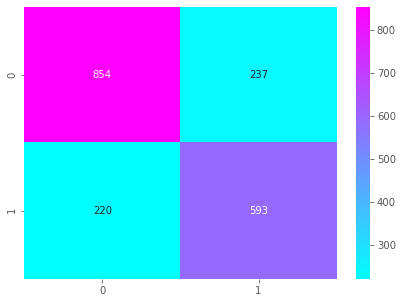

In [96]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1091
           1       0.71      0.73      0.72       813

    accuracy                           0.76      1904
   macro avg       0.75      0.76      0.76      1904
weighted avg       0.76      0.76      0.76      1904



### Next Model

In [114]:
test.head()

,text
0,happened terrible car crash
1,heard earthquake different cities stay safe ev...
2,forest fire spot pond geese fleeing across str...
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills china taiwan


In [115]:
test

,text
0,happened terrible car crash
1,heard earthquake different cities stay safe ev...
2,forest fire spot pond geese fleeing across str...
3,apocalypse lighting spokane wildfires
4,typhoon soudelor kills china taiwan
...,...
3258,earthquake safety los angeles ûò safety faste...
3259,storm ri worse last hurricane hardest hit yard...
3260,green line derailment chicago
3261,meg issues hazardous weather outlook


In [116]:
x_Test = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(test.text.to_numpy()), padding='pre', maxlen=31)

In [117]:
x_Test.shape

(3263, 31)

In [118]:
l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train['text'].values)
X = tokenizer.texts_to_sequences(train['text'].values)
X = pad_sequences(X, maxlen =l)

In [119]:
from tensorflow.keras import optimizers

In [120]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 100)           500000    
                                                                 
 dropout_11 (Dropout)        (None, 50, 100)           0         
                                                                 
 lstm_13 (LSTM)              (None, 50, 100)           80400     
                                                                 
 dropout_12 (Dropout)        (None, 50, 100)           0         
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 1)               

In [121]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [122]:
z = model.fit(X,y, epochs = 10,validation_split = 0.2 ,callbacks=[es_callback], batch_size=32)

Epoch 1/10
191/191 [==============================] - 21s 91ms/step - loss: 0.5258 - accuracy: 0.7409 - val_loss: 0.4872 - val_accuracy: 0.7636
Epoch 2/10
191/191 [==============================] - 18s 93ms/step - loss: 0.3521 - accuracy: 0.8578 - val_loss: 0.5204 - val_accuracy: 0.7584
Epoch 3/10
191/191 [==============================] - 18s 92ms/step - loss: 0.2806 - accuracy: 0.8857 - val_loss: 0.5872 - val_accuracy: 0.7557
Epoch 4/10
191/191 [==============================] - 17s 91ms/step - loss: 0.2245 - accuracy: 0.9136 - val_loss: 0.6833 - val_accuracy: 0.7577
Epoch 5/10
191/191 [==============================] - 17s 90ms/step - loss: 0.1771 - accuracy: 0.9312 - val_loss: 0.8175 - val_accuracy: 0.7295
Epoch 6/10
191/191 [==============================] - 17s 90ms/step - loss: 0.1383 - accuracy: 0.9422 - val_loss: 1.0572 - val_accuracy: 0.7144
Epoch 7/10
191/191 [==============================] - 17s 90ms/step - loss: 0.1075 - accuracy: 0.9539 - val_loss: 1.3355 - val_accuracy:

In [123]:
z.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

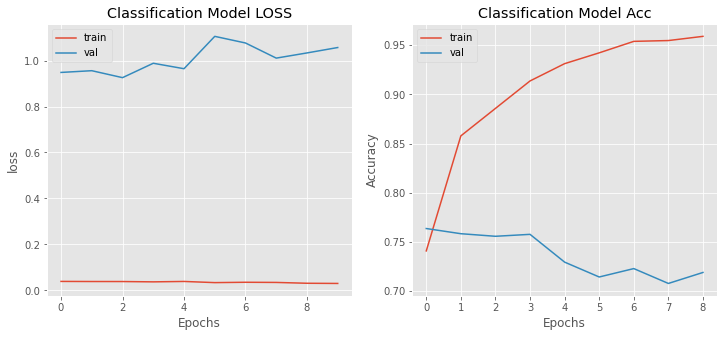

In [125]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(z.history['accuracy']);
plt.plot(z.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [126]:
test_token = tokenizer.texts_to_sequences(test['text'].values)
test_token = pad_sequences(test_token, maxlen =l)

### Second Prediction for Kaggle

In [128]:
y_hat = model.predict(test_token).round()
submission = pd.read_csv("../desktop/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')

In [129]:
submission.to_csv('submission.csv', index=False)

## Results and Analysis

Our results comparing the two models are fairly easy to interpret. We can see that for our bidirectional LSTM model was greatly overfitting the data. This can be seen in the classification model loss and model accuracy plots. The training and validation lines stay on opposite ends of the spectrum on both of them. With that model we acheived a training accuracy of almost 99%, but on the unseen data submitted to Kaggle we achieved a score of only 57%. Our optimizer in this case was "rmsprop" and we did not specify a learning rate for it. For our next LSTM model we had two LSTM layers and used the "adam" optimizer" with a .002 learning rate. This model also overfit the data, but on the first epoch we can see the training and validation accuracies cross. After submitting this models' predictions to Kaggle we got much better results. To be exact, a total accuracy of close to 74% on the unseen data. 

## Conclusion

A huge takeaway I had for this competItion was that the dataset here was much messier than the CNN and much harder for our model to find patterns. Dealing with thousands of humans' language has much more variation than medical images and is therefore harder to normalize. I am sure there are many other and much better ways I could have cleaned the text. It appeared that switching away from the bi-LSTM and using an "adam" optimizer helped us to not overfit the data, quite as much. To conclude there is much more I could have done to help improve the accuracy, but this was a good foundational building project in the realm of NLP.

### Sources

https://www.kaggle.com/code/sandhyakrishnan02/nlp-with-disaster-tweets-using-lstm/notebook

https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm
    
https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

https://www.kaggle.com/code/parulpandey/getting-started-with-nlp-a-general-intro

https://www.kaggle.com/code/akashkotal/nlp-with-disaster-tweets-using-tensorflow/notebook

https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/#:~:text=Bidirectional%20long%2Dshort%20term%20memory,forward(past%20to%20future).